In [1]:
import random
import sys
import mdp
import environment
import util
import optparse

class Gridworld(mdp.MarkovDecisionProcess):
  """
    Gridworld
  """
  def __init__(self, grid):
    # layout
    if type(grid) == type([]): grid = makeGrid(grid)
    self.grid = grid
    
    # parameters
    self.livingReward = -1 # 0.0
    self.noise = 0.2
        
  def setLivingReward(self, reward):
    """
    The (negative) reward for exiting "normal" states.
    
    Note that in the R+N text, this reward is on entering
    a state and therefore is not clearly part of the state's
    future rewards.
    """
    self.livingReward = reward
        
  def setNoise(self, noise):
    """
    The probability of moving in an unintended direction.
    """
    self.noise = noise
        
                                    
  def getPossibleActions(self, state):
    """
    Returns list of valid actions for 'state'.
    
    Note that you can request moves into walls and
    that "exit" states transition to the terminal
    state under the special action "done".
    """
    if state == self.grid.terminalState:
      return ()
    x,y = state
    if type(self.grid[x][y]) == int:
      return ('exit',)
    return ('north','west','south','east')
    
  def getStates(self):
    """
    Return list of all states.
    """
    # The true terminal state.
    states = [self.grid.terminalState]
    for x in range(self.grid.width):
      for y in range(self.grid.height):
        if self.grid[x][y] != '#':
          state = (x,y)
          states.append(state)
    return states
        
  def getReward(self, state, action, nextState):
    """
    Get reward for state, action, nextState transition.
    
    Note that the reward depends only on the state being
    departed (as in the R+N book examples, which more or
    less use this convention).
    """
    if state == self.grid.terminalState:
      return 0.0
    x, y = state
    cell = self.grid[x][y]
    if type(cell) == int or type(cell) == float:
      return cell 
    return self.livingReward
        
  def getStartState(self):
    for x in range(self.grid.width):
      for y in range(self.grid.height):
        if self.grid[x][y] == 'S':
          return (x, y)
    raise 'Grid has no start state'
    
  def isTerminal(self, state):
    """
    Only the TERMINAL_STATE state is *actually* a terminal state.
    The other "exit" states are technically non-terminals with
    a single action "exit" which leads to the true terminal state.
    This convention is to make the grids line up with the examples
    in the R+N textbook.
    """
    return state == self.grid.terminalState
        
                   
  def getTransitionStatesAndProbs(self, state, action):
    """
    Returns list of (nextState, prob) pairs
    representing the states reachable
    from 'state' by taking 'action' along
    with their transition probabilities.          
    """        
        
    if action not in self.getPossibleActions(state):
      raise "Illegal action!"
      
    if self.isTerminal(state):
      return []
    
    x, y = state
    
    if type(self.grid[x][y]) == int or type(self.grid[x][y]) == float:
      termState = self.grid.terminalState
      return [(termState, 1.0)]
      
    successors = []                
                
    northState = (self.__isAllowed(y+1,x) and (x,y+1)) or state
    westState = (self.__isAllowed(y,x-1) and (x-1,y)) or state
    southState = (self.__isAllowed(y-1,x) and (x,y-1)) or state
    eastState = (self.__isAllowed(y,x+1) and (x+1,y)) or state
                        
    if action == 'north' or action == 'south':
      if action == 'north': 
        successors.append((northState,1-self.noise))
      else:
        successors.append((southState,1-self.noise))
                                
      massLeft = self.noise
      successors.append((westState,massLeft/2.0))    
      successors.append((eastState,massLeft/2.0))
                                
    if action == 'west' or action == 'east':
      if action == 'west':
        successors.append((westState,1-self.noise))
      else:
        successors.append((eastState,1-self.noise))
                
      massLeft = self.noise
      successors.append((northState,massLeft/2.0))
      successors.append((southState,massLeft/2.0)) 
      
    successors = self.__aggregate(successors)
                                                                           
    return successors                                
  
  def __aggregate(self, statesAndProbs):
    counter = util.Counter()
    for state, prob in statesAndProbs:
      counter[state] += prob
    newStatesAndProbs = []
    for state, prob in counter.items():
      newStatesAndProbs.append((state, prob))
    return newStatesAndProbs
        
  def __isAllowed(self, y, x):
    if y < 0 or y >= self.grid.height: return False
    if x < 0 or x >= self.grid.width: return False
    return self.grid[x][y] != '#'

class GridworldEnvironment(environment.Environment):
    
  def __init__(self, gridWorld):
    self.gridWorld = gridWorld
    self.reset()
            
  def getCurrentState(self):
    return self.state
        
  def getPossibleActions(self, state):        
    return self.gridWorld.getPossibleActions(state)
        
  def doAction(self, action):
    successors = self.gridWorld.getTransitionStatesAndProbs(self.state, action) 
    sum = 0.0
    rand = random.random()
    state = self.getCurrentState()
    for nextState, prob in successors:
      sum += prob
      if sum > 1.0:
        raise 'Total transition probability more than one; sample failure.' 
      if rand < sum:
        reward = self.gridWorld.getReward(state, action, nextState)
        self.state = nextState
        return (nextState, reward)
    raise 'Total transition probability less than one; sample failure.'    
        
  def reset(self):
    self.state = self.gridWorld.getStartState()

class Grid:
  """
  A 2-dimensional array of immutables backed by a list of lists.  Data is accessed
  via grid[x][y] where (x,y) are cartesian coordinates with x horizontal,
  y vertical and the origin (0,0) in the bottom left corner.  
  
  The __str__ method constructs an output that is oriented appropriately.
  """
  def __init__(self, width, height, initialValue=' '):
    self.width = width
    self.height = height
    self.data = [[initialValue for y in range(height)] for x in range(width)]
    self.terminalState = 'TERMINAL_STATE'
    
  def __getitem__(self, i):
    return self.data[i]
  
  def __setitem__(self, key, item):
    self.data[key] = item
    
  def __eq__(self, other):
    if other == None: return False
    return self.data == other.data
    
  def __hash__(self):
    return hash(self.data)
  
  def copy(self):
    g = Grid(self.width, self.height)
    g.data = [x[:] for x in self.data]
    return g
  
  def deepCopy(self):
    return self.copy()
  
  def shallowCopy(self):
    g = Grid(self.width, self.height)
    g.data = self.data
    return g
    
  def _getLegacyText(self):
    t = [[self.data[x][y] for x in range(self.width)] for y in range(self.height)]
    t.reverse()
    return t
    
  def __str__(self):
    return str(self._getLegacyText())

def makeGrid(gridString):
  width, height = len(gridString[0]), len(gridString)
  grid = Grid(width, height)
  for ybar, line in enumerate(gridString):
    y = height - ybar - 1
    for x, el in enumerate(line):
      grid[x][y] = el
  return grid    
             

def getCliffGrid():
  grid = [[' ', ' ', ' ', ' '],
          [' ', ' ', ' ', ' '],
          [' ', ' ', ' ', ' '],
          ['S', -100,-100, 10]]
  return Gridworld(grid)

def getCliffGrid2():
  grid = [[' ', ' ', ' ', ' ', ' ', ' '],
          [' ', ' ', ' ', ' ', ' ', ' '],
          [' ', ' ', ' ', ' ', ' ', ' '],
          ['S', -100,-100, -100,-100, 10]]
  return Gridworld(grid)

def getBookGrid():
  grid = [[' ',' ',' ',+1],
          [' ','#',' ',-1],
          ['S',' ',' ',' ']]
  return Gridworld(grid)


def getUserAction(state, actionFunction):
  """
  Get an action from the user (rather than the agent).
  
  Used for debugging and lecture demos.
  """
  action = None
  while True:
    keys = input('Move with <w,s,a,d> + Enter. Press q + Enter to quit ')
    if 'w' in keys: action = 'north'
    if 's' in keys: action = 'south'
    if 'a' in keys: action = 'west'
    if 'd' in keys: action = 'east'
    if 'q' in keys: sys.exit(0)
    if action == None: continue
    break
  actions = actionFunction(state)
  if action not in actions:
    action = actions[0]
  return action

def printString(x): print(x)

def runEpisode(agent, environment, discount, decision, display, message, pause, episode):
  returns = 0
  totalDiscount = 1.0
  environment.reset()

  if 'startEpisode' in dir(agent): agent.startEpisode()
  message("BEGINNING EPISODE: "+str(episode)+"\n")
  while True:
    # DISPLAY CURRENT STATE
    state = environment.getCurrentState()
    display(state)
    pause()

    # END IF IN A TERMINAL STATE
    actions = environment.getPossibleActions(state)
    if len(actions) == 0:
      message("EPISODE "+str(episode)+" COMPLETE: RETURN WAS "+str(returns)+"\n")
      return returns

    # GET ACTION (USUALLY FROM AGENT)
    action = decision(state)
    if action == None:
      raise 'Error: Agent returned None action'
    
    # EXECUTE ACTION
    nextState, reward = environment.doAction(action)
    message("Started in state: "+str(state)+
            "\nTook action: "+str(action)+
            "\nEnded in state: "+str(nextState)+
            "\nGot reward: "+str(reward)+"\n")    
    # UPDATE LEARNER
    if 'observeTransition' in dir(agent): 
        agent.observeTransition(state, action, nextState, reward)
    
    returns += reward * totalDiscount
    totalDiscount *= discount

  if 'stopEpisode' in dir(agent):
    agent.stopEpisode()

def parseOptions():
    optParser = optparse.OptionParser()
    optParser.add_option('-d', '--discount',action='store',
                         type='float',dest='discount',default=0.9,
                         help='Discount on future (default %default)')
    optParser.add_option('-r', '--livingReward',action='store',
                         type='float',dest='livingReward',default=-1.0,
                         metavar="R", help='Reward for living for a time step (default %default)')
    optParser.add_option('-n', '--noise',action='store',
                         type='float',dest='noise',default=0.0,
                         metavar="P", help='How often action results in ' +
                         'unintended direction (default %default)' )
    optParser.add_option('-e', '--epsilon',action='store',
                         type='float',dest='epsilon',default=0.3,
                         metavar="E", help='Chance of taking a random action in q-learning (default %default)')
    optParser.add_option('-l', '--learningRate',action='store',
                         type='float',dest='learningRate',default=0.5,
                         metavar="P", help='TD learning rate (default %default)' )
    optParser.add_option('-i', '--iterations',action='store',
                         type='int',dest='iters',default=10,
                         metavar="K", help='Number of rounds of value iteration (default %default)')
    optParser.add_option('-k', '--episodes',action='store',
                         type='int',dest='episodes',default=1,
                         metavar="K", help='Number of epsiodes of the MDP to run (default %default)')
    optParser.add_option('-g', '--grid',action='store',
                         metavar="G", type='string',dest='grid',default="CliffGrid",
                         help='Grid to use (case sensitive; options are BookGrid, CliffGrid' )
    optParser.add_option('-w', '--windowSize', metavar="X", type='int',dest='gridSize',default=150,
                         help='Request a window width of X pixels *per grid cell* (default %default)')
    optParser.add_option('-a', '--agent',action='store', metavar="A",
                         type='string',dest='agent',default="random",
                         help='Agent type (options are \'random\', \'value\' and \'q\', default %default)')
    optParser.add_option('-p', '--pause',action='store_true',
                         dest='pause',default=False,
                         help='Pause GUI after each time step when running the MDP')
    optParser.add_option('-q', '--quiet',action='store_true',
                         dest='quiet',default=False,
                         help='Skip display of any learning episodes')
    optParser.add_option('-s', '--speed',action='store', metavar="S", type=float,
                         dest='speed',default=1.0,
                         help='Speed of animation, S > 1.0 is faster, 0.0 < S < 1.0 is slower (default %default)')
    optParser.add_option('-m', '--manual',action='store_true',
                         dest='manual',default=False,
                         help='Manually control agent')
    optParser.add_option('-v', '--valueSteps',action='store_true' ,default=False,
                         help='Display each step of value iteration')

    opts, args = optParser.parse_args()
    
    if opts.manual and opts.agent != 'q':
      print('## Disabling Agents in Manual Mode (-m) ##')
      opts.agent = None

    # MANAGE CONFLICTS
    if opts.quiet:      
      opts.pause = False
      
    if opts.manual:
      opts.pause = True
      
    return opts

In [5]:
import gridworld

# opts
grid = 'CliffGrid'
livingReward = -1 
noise = 0.0

mdpFunction = getattr(gridworld, "get"+ grid)
mdp = mdpFunction()
mdp.setLivingReward(livingReward)
mdp.setNoise(noise)
env = gridworld.GridworldEnvironment(mdp)

In [6]:
# ###########################
# # GET THE DISPLAY ADAPTER
# ###########################

import textGridworldDisplay
display = textGridworldDisplay.TextGridworldDisplay(mdp)
display.start()

In [10]:
# display 
displayCallback = lambda state: display.displayNullValues(state)

state = env.getCurrentState()
displayCallback(state)

--  -------  -------  -----



S*  -100.00  -100.00  10.00
--  -------  -------  -----


## Value Iteration
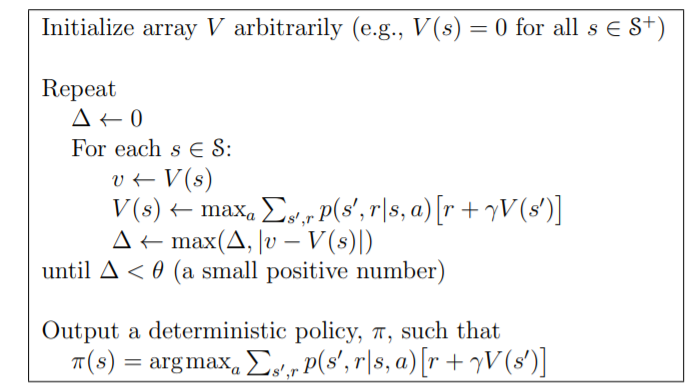

In [ ]:
'''
class ValueIterationAgent(ValueEstimationAgent):

  def __init__(self, mdp, discount = 0.9, iterations = 100):
        ...
'''

In [12]:
# States, S
states = mdp.getStates()
print(states)

['TERMINAL_STATE', (0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [16]:
i_s = 1 # state idx
i_a = 0 # action idx

# Actions, A, in 1 particular state, s
actions = mdp.getPossibleActions(states[i_s])
print(actions)

('north', 'west', 'south', 'east')


In [22]:
# P(.|s,a)
transitions = mdp.getTransitionStatesAndProbs(states[i_s], actions[i_a])
print(transitions)

[((0, 1), 1.0), ((0, 0), 0.0), ((1, 0), 0.0)]


In [24]:
# reward a 
reward = mdp.getReward(states[i_s], actions[i_a], transitions[0][0]) # state, action, nextState
print(reward)

-1


In [ ]:
decisionCallback = a.getAction  

'''
def runEpisode(agent, environment, discount, decision, display, message, pause, episode):
  returns = 0
  totalDiscount = 1.0
  environment.reset()

  if 'startEpisode' in dir(agent): agent.startEpisode()
  message("BEGINNING EPISODE: "+str(episode)+"\n")
  while True:
    # DISPLAY CURRENT STATE
    state = environment.getCurrentState()
    display(state)
    pause()

    # END IF IN A TERMINAL STATE
    actions = environment.getPossibleActions(state)
    if len(actions) == 0:
      message("EPISODE "+str(episode)+" COMPLETE: RETURN WAS "+str(returns)+"\n")
      return returns

    # GET ACTION (USUALLY FROM AGENT)
    action = decision(state)

    if action == None:
      raise 'Error: Agent returned None action'
    
    # EXECUTE ACTION
    nextState, reward = environment.doAction(action)
    message("Started in state: "+str(state)+
            "\nTook action: "+str(action)+
            "\nEnded in state: "+str(nextState)+
            "\nGot reward: "+str(reward)+"\n")    
    # UPDATE LEARNER
    if 'observeTransition' in dir(agent): 
        agent.observeTransition(state, action, nextState, reward)
    
    returns += reward * totalDiscount
    totalDiscount *= discount

  if 'stopEpisode' in dir(agent):
    agent.stopEpisode()
    
'''

## Q-Learning
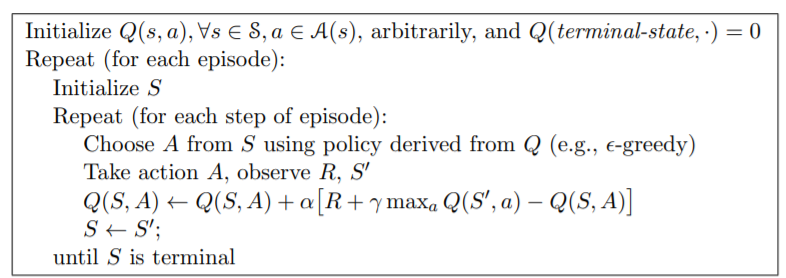

In [26]:
'''
class QLearningAgent(ReinforcementAgent):
    def __init__(self, **args):
    "You can initialize Q-values here..."
    ReinforcementAgent.__init__(self, **args)

    self.epsilon = args['epsilon']
    self.alpha = args['alpha']
    self.gamma = args['gamma']
    self.actionFn = args['actionFn']
'''

'\nclass QLearningAgent(ReinforcementAgent):\n    def __init__(self, **args):\n    "You can initialize Q-values here..."\n    ReinforcementAgent.__init__(self, **args)\n\n    self.epsilon = args[\'epsilon\']\n    self.alpha = args[\'alpha\']\n    self.gamma = args[\'gamma\']\n    self.actionFn = args[\'actionFn\']\n'